<h2 align=center>Preprocessing, Classification, and Error Analysis of Titanic Dataset</h2>

In [1]:
# import required libraries for reading the data, preprocessing and classififying the data
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the train.csv file of the titanic dataset as a pandas dataframe
titanic_df = pd.read_csv('./train.csv')

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<hr/>

<h3>Preprocessing</h3>

In [3]:
def preprocess(df):
    # fill NaN values
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)

    # Replace Cabin values with the first letter of the same values
    df['Cabin'] = df['Cabin'].str[:1]

    # Drop the PassengerId, Name, and Ticket columns
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

    # Convert values of Cabin, Sex, and Embarked columns into numeric values using Label Encoding
    features = ['Cabin', 'Sex', 'Embarked']
    lab_enc = LabelEncoder()
    
    for feature in features:
        lab_enc.fit(df[feature])
        df[feature] = lab_enc.transform(df[feature])
        
    return df

In [4]:
# preprocess the dataframe
titanic_df = preprocess(titanic_df)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,7,3


In [5]:
# Set the input and output features and create train and test sets

def train_test_set(df):
    """
    Takes dataframe as the input and returns the dataframes X_train, X_test, y_train, y_test
    """
    # make the Survived column as output and all other columns as input features
    X = df.loc[:, df.columns != 'Survived']
    y = df['Survived']

    return train_test_split(X, y, test_size=0.1, random_state=23)

In [6]:
# get the train and test sets
X_train, X_test, y_train, y_test = train_test_set(titanic_df)
print(f"Number of samples in training data: {X_train.shape[0]}")
print(f"Number of samples in test data: {X_test.shape[0]}")

Number of samples in training data: 801
Number of samples in test data: 90


<hr/>
<h3>Model Training</h3>

In [7]:
# Train a Decision Tree Classifier and find the optimal hyperparameters

# Initialize a Decision Tree Classifier model
dt_clf = DecisionTreeClassifier()

hyperparams = {'max_depth': [2, 3, 5, 10],
               'min_samples_split': [2, 3, 5],
               'min_samples_leaf': [1, 5, 8]}

grid_dt_clf = GridSearchCV(estimator=dt_clf, param_grid=hyperparams, cv=5)

grid_dt_clf.fit(X_train, y_train)

print('Optimal Hyperparameters:\n', grid_dt_clf.best_params_)
print('\nBest Training Accuracy: {:.2f}'.format(grid_dt_clf.best_score_))

Optimal Hyperparameters:
 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Training Accuracy: 0.81


<hr/>

<h3>Error Analysis</h3>

In [8]:
# import error metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

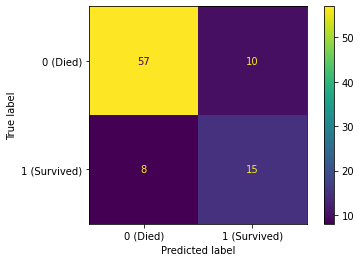

In [9]:
# plot the confusion matrix for the test set
plot_confusion_matrix(grid_dt_clf, X_test, y_test, display_labels=['0 (Died)', '1 (Survived)'])
plt.show()

In [10]:
# Evaluate the classifier's performance on the test set based on the error metrics
def clf_eval(y_test, preds=None, pred_proba=None):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}, ROC-AUC Score: {:.2f}"
            .format(accuracy, precision, recall, f1, roc_auc))

In [11]:
# predicted labels for test set
preds = grid_dt_clf.predict(X_test)

# predicted probabilities for test set when the label is 1 (survived)
pred_proba = grid_dt_clf.predict_proba(X_test)[:, 1]

clf_eval(y_test, preds, pred_proba)

Accuracy: 0.80, Precision: 0.60, Recall: 0.65, F1-score: 0.63, ROC-AUC Score: 0.80


### Precision Recall Curve

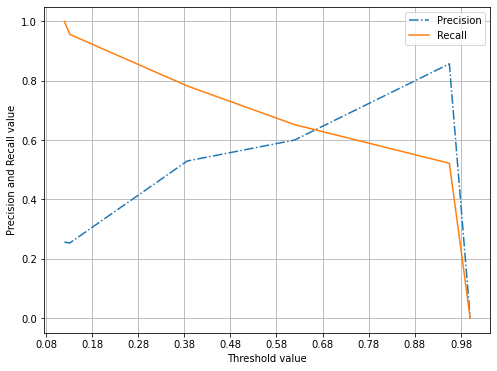

In [12]:
# Precision and Recall curves for different threshold values
def precision_recall_curve_plot(y_test , pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], linestyle='-.', label='Precision')
    plt.plot(thresholds, recalls[:threshold_boundary], label='Recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, pred_proba)

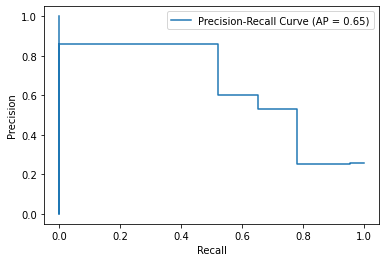

In [13]:
# Precision-Recall curve
plot_precision_recall_curve(grid_dt_clf, X_test, y_test, name='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### ROC Curve

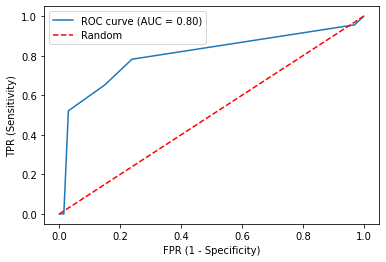

In [14]:
plot_roc_curve(grid_dt_clf, X_test, y_test, name='ROC curve')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.legend()
plt.show()

<hr/>
<h1 align=center>Thank You</h1>